In [1]:
import sys
import os

import sklearn
import tensorflow as tf
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

np.random.seed(42)

# 10.1 생물학적 뉴런에서 인공 뉴런까지

## 10.1.3 퍼셉트론

In [2]:
def heaviside_step_function(z):
    if z < 0:
        return 0
    else:
        return 1

def sign_function(z):
    if z < 0:
        return -1
    elif z == 0:
        return 0
    else:
        return 1

In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [4]:
y_pred

array([1])

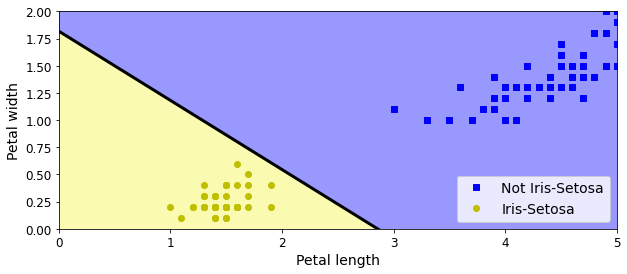

In [5]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 500).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], 'bs', label='Not Iris-Setosa')
plt.plot(X[y==1, 0], X[y==1, 1], 'yo', label='Iris-Setosa')

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], 'k-', linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])  

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel('Petal length', fontsize=14)
plt.ylabel('Petal width', fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.axis(axes)

plt.show()

## 10.1.4 다층 퍼셉트론과 역전파

In [6]:
# 활성화함수(activation function)
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

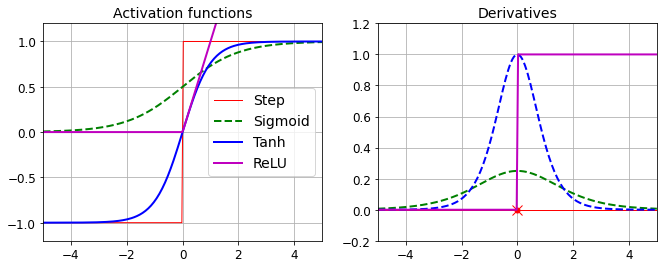

In [7]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(z, np.sign(z), 'r-', linewidth=1, label='Step')
plt.plot(z, sigmoid(z), 'g--', linewidth=2, label='Sigmoid')
plt.plot(z, np.tanh(z), 'b-', linewidth=2, label='Tanh')
plt.plot(z, relu(z), 'm-', linewidth=2, label='ReLU')
plt.grid(True)
plt.legend(loc='center right', fontsize=14)
plt.title('Activation functions', fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), 'r-', linewidth=1, label='Step')
plt.plot(0, 0, 'ro', markersize=5)
plt.plot(0, 0, 'rx', markersize=10)
plt.plot(z, derivative(sigmoid, z), 'g--', linewidth=2, label='Sigmoid')
plt.plot(z, derivative(np.tanh, z), 'b--', linewidth=2, label='Tanh')
plt.plot(z, derivative(relu, z), 'm-', linewidth=2, label='ReLU')
plt.grid(True)

# plt.legend(loc='center right', fontsize=14)
plt.title('Derivatives', fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

In [8]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

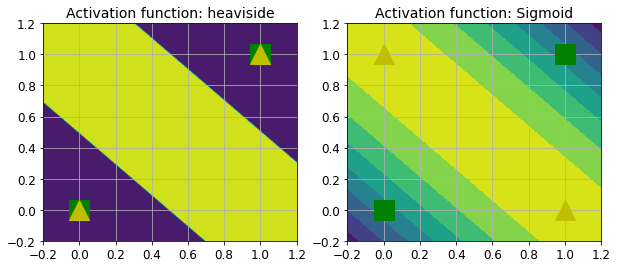

In [9]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], 'gs', markersize=20)
plt.plot([0, 1], [0, 1], 'y^', markersize=20)
plt.title('Activation function: heaviside', fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], 'gs', markersize=20)
plt.plot([0, 1], [1, 0], 'y^', markersize=20)
plt.title('Activation function: Sigmoid', fontsize=14)
plt.grid(True)

# 10.2 케라스로 다층 퍼셉트론 구현하기

## 10.2.2 시퀀셜 API를 사용하여 이미지 분류기 만들기

In [10]:
import tensorflow as tf
from tensorflow import keras

In [11]:
tf.__version__

'2.4.1'

In [12]:
keras.__version__

'2.4.0'

In [13]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [14]:
X_train_full.shape

(60000, 28, 28)

In [15]:
X_train_full.dtype

dtype('uint8')

In [16]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

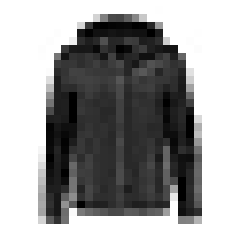

In [17]:
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')
plt.show()

In [18]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [19]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [20]:
class_names[y_train[0]]

'Coat'

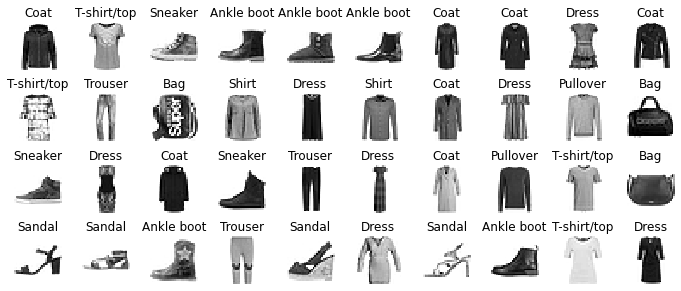

In [21]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap='binary', interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [22]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [23]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [24]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [25]:
model.layers

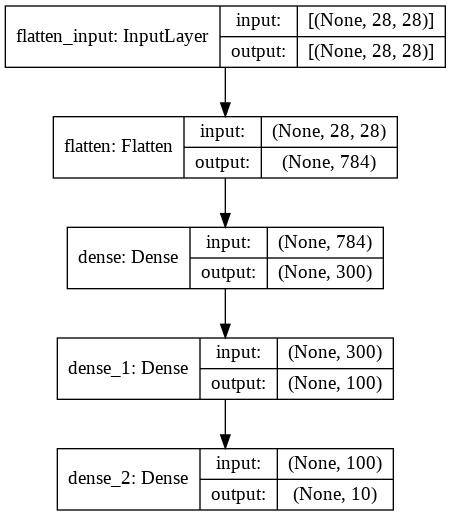

In [26]:
keras.utils.plot_model(model, show_shapes=True)

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [28]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [29]:
model.get_layer(hidden1.name) is hidden1

True

In [30]:
weights, biases = hidden1.get_weights()

In [31]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [32]:
weights.shape

(784, 300)

In [33]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [34]:
biases.shape

(300,)

In [35]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [36]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 1.0187 - accuracy: 0.6805 - val_loss: 0.5211 - val_accuracy: 0.8230
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5028 - accuracy: 0.8258 - val_loss: 0.4352 - val_accuracy: 0.8524
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4486 - accuracy: 0.8426 - val_loss: 0.5317 - val_accuracy: 0.7992
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4208 - accuracy: 0.8529 - val_loss: 0.3916 - val_accuracy: 0.8654
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4060 - accuracy: 0.8583 - val_loss: 0.3742 - val_accuracy: 0.8694
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3753 - accuracy: 0.8673 - val_loss: 0.3715 - val_accuracy: 0.8730
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3654 - accuracy: 0.8701 - val_loss: 0.3620 - val_accuracy:

In [37]:
history.params

{'epochs': 30, 'steps': 1719, 'verbose': 1}

In [38]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

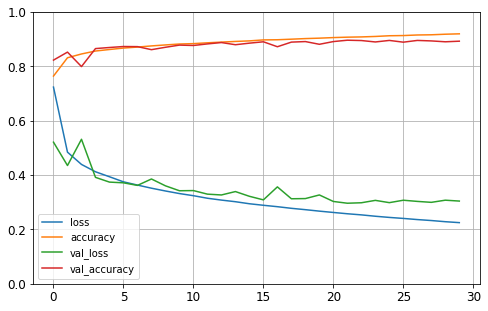

In [40]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()